In [10]:
# get new data from github repository https://github.com/CSSEGISandData/COVID-19
import subprocess
process = subprocess.Popen("cd COVID-19 & git fetch & git pull", stdout=subprocess.PIPE, shell=True)
print(process.communicate()[0].strip().decode())

Already up to date.


In [45]:
# imports and globals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
BASE_DIRECTORY = "COVID-19\\csse_covid_19_data\\csse_covid_19_time_series\\"

COUNTRY_DATA = {
    "United Kingdom": {
        "population": 66440000, #2018
        "province": "",
    },
    "France": {
        "population": 66990000, #2019
        "province": "",
    },
    "Germany": {
        "population": 82790000, #2018
        "province": "",
    },
    "Spain": {
        "population":46660000, #2018
        "province": "",
    },
    "Italy" : {
        "population":60480000, #2018
        "province": "",
    },
    "China" : {
        "population": 59020000, # 2017 just Hubei
        "province": "Hubei",
    },
    "Korea, South": {
        "population": 51470000, #2017
        "province": "",
    },
    "US": {
        "population": 327200000, #2018
        "province": "",
    },
    "New York": {
        "population": 8623000, #2017
        "province": "",
    }
}


In [46]:
# load the datasets
confirmed = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_confirmed_global.csv"))
deaths = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_deaths_global.csv"))
recovered = pd.read_csv(join(BASE_DIRECTORY, "time_series_covid19_recovered_global.csv"))

# load the US dataset (which is in a different format)
confirmed_US = pd.read_csv(join(BASE_DIRECTORY,"time_series_covid19_confirmed_US.csv"))
deaths_US = pd.read_csv(join(BASE_DIRECTORY,"time_series_covid19_deaths_US.csv"))

In [47]:

def read_us(confirmed_US, deaths_US, state: str):
    global deaths, confirmed
    """
    accept a US formatted dataframe, which could be filtered by state
    """
    
    confirmed_US_sum = pd.Series()
    deaths_US_sum = pd.Series()

    for column in confirmed_US:
        try:
            confirmed_US_sum[column] = int(confirmed_US[column].sum())
            deaths_US_sum[column] = int(deaths_US[column].sum())

        except Exception as e:
            confirmed_US_sum[column] = ""
            deaths_US_sum[column] = ""
    
    # Need to reformat it a bit
    try:
        confirmed_US_sum = confirmed_US_sum.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
        deaths_US_sum = deaths_US_sum.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
    except:
        # already done
        pass

    confirmed_US_sum['Province/State'] = ""
    confirmed_US_sum['Country/Region'] = state
    confirmed_US_sum['Lat'] = 0
    confirmed_US_sum['Long'] = 0
    
    deaths_US_sum['Province/State'] = ""
    deaths_US_sum['Country/Region'] = state
    deaths_US_sum['Lat'] = 0
    deaths_US_sum['Long'] = 0

    # format to df and reorder the columns
    us_deaths = deaths_US_sum.to_frame().T
    us_deaths = us_deaths[deaths.columns]

    us_confirmed = confirmed_US_sum.to_frame().T
    us_confirmed = us_confirmed[confirmed.columns]


    # merge the datasets
    
    confirmed = pd.concat([confirmed, us_confirmed], ignore_index=True)
    
    deaths = pd.concat([deaths, us_deaths], ignore_index=True)
    
    return confirmed, deaths



In [48]:
states = ["New York"]
for state in states:
    confirmed, deaths = read_us(confirmed_US[confirmed_US["Province_State"] == state], deaths_US[deaths_US["Province_State"] == state], state)


In [49]:

def load(country: str, state: str) -> pd.DataFrame:
    """
    returns a country as a pandas dataframes with confirmed, deaths, recovered as columns, dates as index
    """
    # could do the following as a loop but eh

    # confirmed
    country_df = confirmed[confirmed['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    confirmed_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # deaths
    country_df = deaths[deaths['Country/Region'] == country].replace(np.nan, "")
    state_df = country_df[country_df['Province/State'] == state]
    deaths_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T

    # recovered
    # try except to deal with US states without recovered data
    try:
        country_df = recovered[recovered['Country/Region'] == country].replace(np.nan, "")
        state_df = country_df[country_df['Province/State'] == state]
        recovered_result = state_df.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1).T
        recovered_result[0]
    except:
        recovered_result = deaths_result

    # combine the series to one dataframe
    df_result = pd.concat([confirmed_result, deaths_result, recovered_result], axis =1)
    df_result.columns = ["confirmed", "deaths", "recovered"]
    df_result.index = pd.to_datetime(df_result.index)

    return df_result


In [50]:
# load the data for each country into the dictionary

for country in COUNTRY_DATA.keys():
    # get the data
    df = load(country, COUNTRY_DATA[country]['province'])
    COUNTRY_DATA[country]['data'] = df
    # Normalise data with population figures
    normalise = lambda x: x/COUNTRY_DATA[country]['population'] * 100
    COUNTRY_DATA[country]['normalised_data'] = df.apply(normalise)


In [51]:
# Now we have normalised death values, we need normalised dates. We should only compare counties from the date the virus started killing
# Find the first day of a death for each country
first_day = lambda df: df.deaths[df.deaths <= 0.0001].index[-1]
# need to convert the index to days since the first day
convert_index = lambda df: df[df.index >= first_day(df)].reset_index()

Text(0, 0.5, 'Percentage of the population')

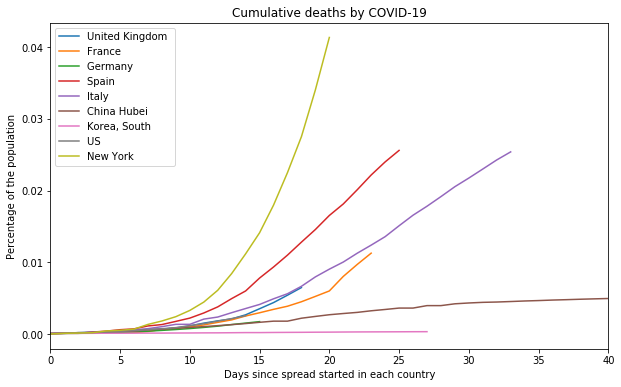

In [52]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
for country in COUNTRY_DATA.keys():
    ax.plot(convert_index(COUNTRY_DATA[country]['normalised_data']).deaths)
ax.legend([country + " " + COUNTRY_DATA[country]['province'] for country in COUNTRY_DATA.keys()])
ax.set_xlim([0, 40])
plt.title("Cumulative deaths by COVID-19")
plt.xlabel("Days since spread started in each country")
plt.ylabel("Percentage of the population")

In [32]:
# plot an interactive version using bokeh

from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Colorblind as palette
from itertools import cycle
import bokeh.models

colours = cycle(palette[8])
countries = list(COUNTRY_DATA.keys())
fig = figure(
    x_axis_label='Days since deaths started in each country', 
    y_axis_label='Percentage of the population',
    plot_width=800,
    plot_height=500,
    id="plot_1",
    active_drag="pan",
    active_scroll="wheel_zoom",
    )

# add the hover tool and configure it to be useful
fig.add_tools(bokeh.models.HoverTool())
hover = fig.select(dict(type=bokeh.models.HoverTool))
hover.tooltips = [("Country", "@series_name"), ("Day", "@x"),  ("Value", "@y"),]
hover.mode = 'mouse'

for country in countries:
    series = convert_index(COUNTRY_DATA[country]['normalised_data']).deaths
    fig.line(series.index, series.values, legend_label=country, line_width=2, color=next(colours))

output_file("log_lines.html")
show(fig)

In [ ]:
# Now try to predict what the number of deaths will be in the future based on current trajectory (& the confirmed cases?)


In [53]:
# Get an accelertion measure for confirmed / deaths
import numpy as np

def acceleration(country):
    """
    get the accelation of deaths and confimred cases for a country
    """
    # confirmed
    df = COUNTRY_DATA[country]['data'].confirmed.diff()
    df = df[df.index > (pd.Timestamp.now() - pd.Timedelta(days=8))]
    bestfit = np.polyfit(x=range(7), y=df.values, deg=1)
    confirmed_gradient = bestfit[0] / COUNTRY_DATA[country]['population']
    
    # deaths
    df = COUNTRY_DATA[country]['data'].deaths.diff()
    df = df[df.index > (pd.Timestamp.now() - pd.Timedelta(days=8))]
    bestfit = np.polyfit(x=range(7), y=df.values, deg=1)
    deaths_gradient = bestfit[0] / COUNTRY_DATA[country]['population']
    
    return confirmed_gradient, deaths_gradient


def sum(country):
    """
    get the total number of confirmed / deaths for each country
    """
    return COUNTRY_DATA[country]['data'].confirmed.sum(), COUNTRY_DATA[country]['data'].deaths.sum()

acceleration('United Kingdom')


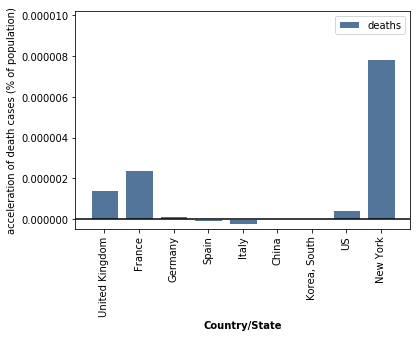

In [116]:
# make bar charts with accerlation/sum for confirmed/deaths for each country
# do with matplotlib as bokeh is being a bitch
# stacked example

countries = list(COUNTRY_DATA.keys())

# set width of bar
barWidth = 0.8
 
# set height of bar
deaths_accel = [acceleration(country)[1] for country in countries]
confirmed_accel = [acceleration(country)[0] for country in countries]
 
# Set position of bar on X axis
r1 = np.arange(len(deaths_accel))
 
# Make the plot
plt.bar(r1, deaths_accel, color='#537599', width=barWidth, edgecolor='white', label='deaths')
 
# Add xticks on the middle of the group bars
plt.xlabel('Country/State', fontweight='bold')
plt.ylabel("acceleration of death cases (% of population)")
plt.xticks(np.arange(len(countries)), countries)
plt.xticks(rotation=90)
plt.axhline(0, color='black')

plt.ylim(bottom=min(deaths_accel)*2, top=max(deaths_accel) * 1.3)

# Create legend & Show graphic
plt.legend()
plt.show()

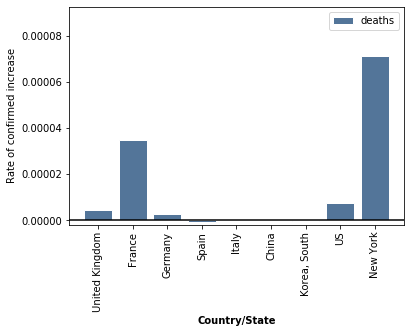

In [114]:
countries = list(COUNTRY_DATA.keys())

# set width of bar
barWidth = 0.8
 
# set height of bar
confirmed_accel = [acceleration(country)[0] for country in countries]
 
# Set position of bar on X axis
r1 = np.arange(len(deaths_accel))
 
# Make the plot
plt.bar(r1, confirmed_accel, color='#537599', width=barWidth, edgecolor='white', label='confirmed cases')
 
# Add xticks on the middle of the group bars
plt.xlabel('Country/State', fontweight='bold')
plt.ylabel("acceleration of confirmed cases (% of population)")
plt.xticks(np.arange(len(countries)), countries)
plt.xticks(rotation=90)
plt.axhline(0, color='black')

plt.ylim(bottom=min(confirmed_accel)*2, top=max(confirmed_accel) * 1.3)


# Create legend & Show graphic
plt.legend()
plt.show()